# Testing tig and forge on a collection
## PO.DAAC Data Publication Team
#### *Author: Dean Henze*

This notebook can be used to test
1. Generation of a tig-forge configuration file from a test granule.
2. Use of the config file and a test granule with tig to generate image thumbnails (used in HiTIDE GUI).
3. Use of the config file and a test granule with forge to generate granule footprints (used to visualize individual granule footprints in both HiTIDE and Earthdata Search).
4. There is also guidance on testing collections with L2SS and HiTIDE.

Tests 2 and 3 can be run separately of each other. For example, a DPub engineer might decide that their collection requires footprints for Earthdata search, but won't be part of HiTIDE (and therefore doesn't require image thumbnails).

This notebook uses the tig and forge software, which are maintained by the TVA team. The tig and forge repos can be found at:
* https://github.com/podaac/tig
* https://github.com/podaac/forge

You do not need to install either prior to running this notebook. Installing is part of the below code / workflow.

# Setup and Python Packages

### Python packages other than `podaac-tig`

The following package list represents the minimal working environment to run this notebook
```
Cartopy==0.22.0
click==8.1.7
matplotlib==3.8.3
matplotlib-inline==0.1.6
netCDF4==1.6.5
numpy==1.26.4
pygeogrids==0.5.0
scipy==1.12.0
xarray==2024.2.0
jupyter
```
The packages can be installed however is preferred, but as an example:
```
pip install numpy netCDF4 xarray matplotlib scipy cartopy pygeogrids click jupyter
```

In [3]:
import sys
import os
import shutil
import json
import numpy as np
import matplotlib.pyplot as plt
import cartopy
%matplotlib inline

### `podaac-tig` software / library
We found it easier to clone the repo's locally and then access the needed python scripts from those, rather than installing the package with pip. Therefore, this section uses the git clone method. If you opt for the pip install method, guidance on is given in the `Other Notes` section.

In [1]:
!git clone git@github.com:podaac/forge-tig-configuration.git
!git clone -b release/0.9.0 git@github.com:podaac/tig.git

Cloning into 'forge-tig-configuration'...
remote: Enumerating objects: 502, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 502 (delta 113), reused 104 (delta 93), pack-reused 353
Receiving objects: 100% (502/502), 150.45 KiB | 740.00 KiB/s, done.
Resolving deltas: 100% (322/322), done.
Cloning into 'tig'...
remote: Enumerating objects: 1782, done.
remote: Counting objects: 100% (540/540), done.
remote: Compressing objects: 100% (234/234), done.
remote: Total 1782 (delta 289), reused 466 (delta 285), pack-reused 1242
Receiving objects: 100% (1782/1782), 46.64 MiB | 4.79 MiB/s, done.
Resolving deltas: 100% (916/916), done.


In [4]:
sys.path.append("./tig") # So we can import packages from one of the repo's just downloaded.
from podaac.tig import generate_hitide_config
from podaac.tig import tig

# 1. Generate config file

The config file can be used to either generate footprints with forge, or thumbnails with tig (which ever are relevant to your data set). The config file will be saved as `<collection-short-name>.cfg`. 

Required files/directories to have in the same directory as this notebook:
1. One or more test granules from the collection, in a folder `granules/`. This notebook assumes the file extensions are one of `.nc`, `.hdf`, or `.h5`.
2. A CSV file named `vars.csv` with variable names to add to HiTIDE, along with the min/max values to use for each of their colorscales. The column headers should be `variable`, `min`, `max`. If no variables will go into HiTIDE, keep the CSV file empty with only a header row.

Then, modify the lines in the following block of code (no other code in this Section needs modification).

In [5]:
## User to specify some input args to the generate config function:
    # collection shortname:
dataset_id = "ASCATB_ESDR_L2_WIND_STRESS_V1.1" 
    # Optional: relative path to folder containing granules/ and vars.csv, if different than this notebook:
relpath_inputs = "./"
    # csv file for min/max
include_image_variables = relpath_inputs+"vars.csv" 
    # str's, names of coords in file:
longitude = 'lon' 
latitude = 'lat'
time = 'time'
    # footprint strategy. str, usually 'periodic'. For a full list of strategy options, see the "Other Notes" section further down.
footprint_strategy = 'periodic'

No need for modification from here on:

In [6]:
# Clone the forge-tig-configuration repo (https://github.com/podaac/forge-tig-configuration):
#!git clone git@github.com:podaac/forge-tig-configuration.git

In [7]:
# Paths for granules to test:
dir_granules_test = relpath_inputs+"granules/"
gran_paths = [dir_granules_test + f for f in os.listdir(dir_granules_test) if f.endswith((".nc", ".hdf", ".h5"))]
# Path to color palettes directory (requires that the forge-tig-configuration repo was cloned into this directory):
palette_dir = "./forge-tig-configuration/palettes"
# Path to the config file
config_file= dataset_id + ".cfg"

In [8]:
# Generaterate the config file and print file contents to notebook:
cfg = generate_hitide_config.generate_hitide_config(
    gran_paths[0],
    dataset_id,
    include_image_variables,
    longitude, latitude, time,
    footprint_strategy
    )

with open(config_file, 'w') as fp:
    json.dump(cfg, fp, indent=4)

{
    "shortName": "ASCATB_ESDR_L2_WIND_STRESS_V1.1",
    "latVar": "lat",
    "lonVar": "lon",
    "timeVar": "time",
    "is360": true,
    "tiles": {
        "steps": [
            30,
            14
        ]
    },
    "footprint": {
        "strategy": "periodic",
        "t": "0:0,0:*",
        "s1": "0:*,0:0",
        "b": "*:*,0:*",
        "s2": "0:*,*:*"
    },
    "imgVariables": [
        {
            "id": "en_wind_speed",
            "title": "retrieved equivalent neutral wind speed",
            "units": "m s-1",
            "min": 0.0,
            "max": 20.0,
            "palette": "paletteMedspirationIndexed"
        },
        {
            "id": "en_wind_direction",
            "title": "equivalent neutral wind direction clockwise from North following oceanographic convention",
            "units": "degrees",
            "min": 0.0,
            "max": 360.0,
            "palette": "paletteMedspirationIndexed"
        }
    ],
    "image": {
        "ppd": 16,
    

# 2. Tig thumbnail image generation
No code in this section should need modification other than special cases.

In [9]:
# save the thumbnail images here:
img_dir="./images/" 
!mkdir $img_dir

mkdir: ./images/: File exists


In [10]:
## Generate thumbnails for all test granules:
for g in gran_paths:
    # Specify some additional inputs for the tig class object:
    input_file = g # test granule
    granule_id = input_file.split('/')[-1]

    # Run tig and generate the images:
    image_gen = tig.TIG(input_file, img_dir, config_file, palette_dir)
    image_gen.generate_images(granule_id=granule_id)

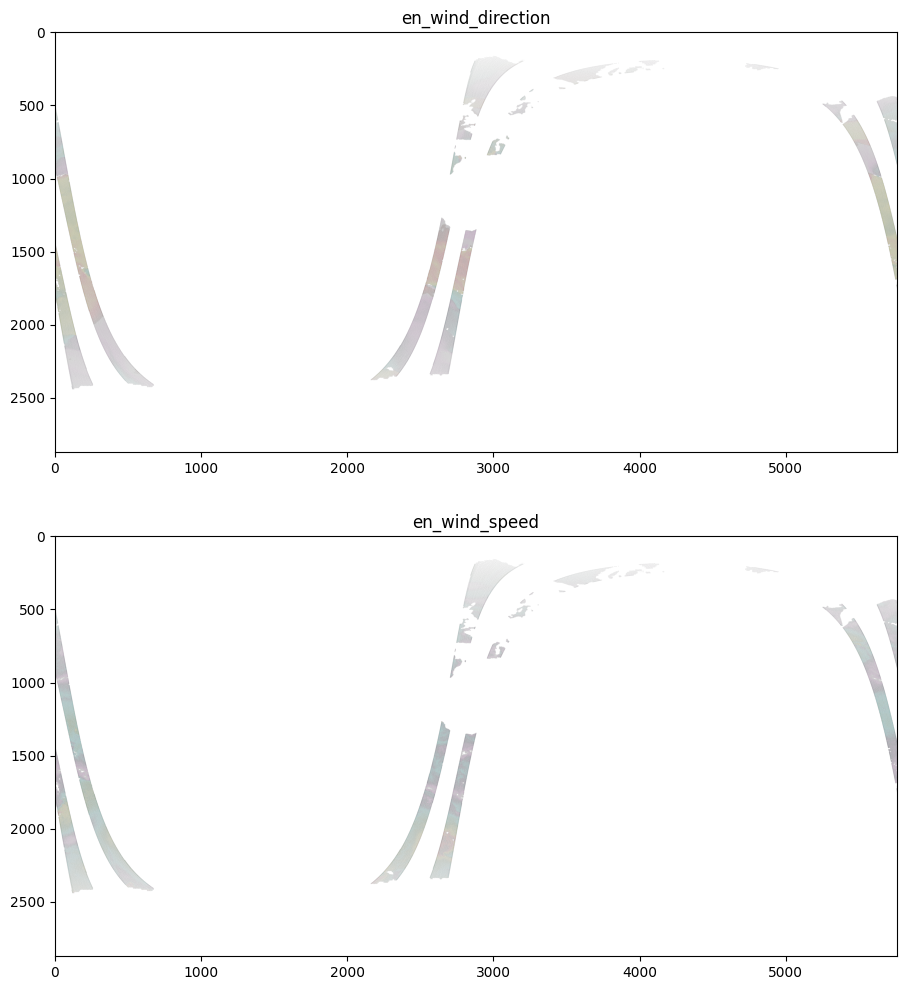

In [11]:
## Test plots of all images:
image_files = [img_dir+f for f in os.listdir(img_dir) if f.endswith(".png")]
fig, axes = plt.subplots(len(image_files),1, figsize=(14, 6*len(image_files)))
if type(axes) is not np.ndarray:
    axes = [axes]
    
for f, ax in zip(image_files, axes):
    img = plt.imread(f)
    im = ax.imshow(img)
    ax.set_title(f.split(".")[-2])
    #plt.axis("off")
plt.show()

# 3. Forge footprint generation
No code in this section should need modification other than special cases.

## 3.1 Download and run forge software:
Note, `forge` is Java software and requires Java 11+

In [12]:
!curl -L -O https://github.com/podaac/forge/releases/download/0.10.0/footprint_0.10.0.jar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 36.2M  100 36.2M    0     0  5495k      0  0:00:06  0:00:06 --:--:-- 7268k


In [13]:
# Directory to store output in:
!mkdir footprints

mkdir: footprints: File exists


In [14]:
# Run forge for all test granules:
for g in gran_paths:
    
    granule_id = g.split('/')[-1]
    
    # Run forge and save output wkt file to granules directory:
    !java -cp "./footprint_0.10.0.jar" FootprintCLI $g $config_file > "./temp_forge_output.txt"
    # Then move wkt file to footprints dir:
    !mv "./granules/"$granule_id".footprint.wkt" "./footprints"

## 3.2 Unpack WKT polygon info and plot

So, far the code assumes that WKT file has one of the following footprint geometries:
```
"POLYGON"
"MULTIPOLYGON" (only works with MULTIPOLYGON's with length 2 so far)
"LINESTRING"
```
And, for example, the `POLYGON` file will look like:
```
"POLYGON ((<lon1 lat1>, <lon2 lat2>, ... <lonN latN>))"
```
where e.g. `<lat1 lon1>` is the first latitue longitude coordinate separated by a blank `" "`, and each latitude longintude pair is separated by a comma.

### ***Also currently, this code is only gauranteed to work for the `periodic` footprint strategy***

In [15]:
def unpack_poly(fn_wkt):
    """
    Unpack polygon lat, lon point info for a WKT footprint file into two lists. 
    'fn_wkt' is the path (str) to the WKT file.
    """
    
    with open(fn_wkt, 'r') as f:
        footprint_wkt = f.read()
        
    # What type of footprint geometry do we have?
    if ('POLYGON' in footprint_wkt) and ('MULTI' not in footprint_wkt): 
        
        temp_fp = footprint_wkt.split("((")[1].split("))")[0]
        
        lons, lats = [[]], [[]]
        for polypoint in temp_fp.split(","):
            lon_p, lat_p = polypoint.split(" ")[-2:]
            lons[0].append(float(lon_p))
            lats[0].append(float(lat_p))

        # Add last point to end so can plot a closed polygon
        lons[0].append(lons[0][0])
        lats[0].append(lats[0][0])

        return lons, lats
    
    elif 'MULTIPOLYGON' in footprint_wkt:
        
        temp_fp = footprint_wkt.split("(")[:]
        temp_fp = (temp_fp[3].split("))")[0], temp_fp[5].split("))")[0])
        
        lons, lats = [[],[]], [[],[]]
        for i in range(2):
            for polypoint in temp_fp[i].split(","):
                lon_p, lat_p = polypoint.split(" ")[-2:]
                lons[i].append(float(lon_p))
                lats[i].append(float(lat_p))
            # Add last point to end so can plot a closed polygon
            lons[i].append(lons[i][0])
            lats[i].append(lats[i][0])
        
        return lons, lats
    
    elif "LINESTRING" in footprint_wkt:
        
        temp_fp = footprint_wkt.split("(")[1].split(")")[0]
        
        lons, lats = [[]], [[]]
        for polypoint in temp_fp.split(","):
            lon_p, lat_p = polypoint.split(" ")[-2:]
            lons[0].append(float(lon_p))
            lats[0].append(float(lat_p))
            
        return lons, lats
        
    else:
        print("WKT file format is not as expected or has a footprint geometry not recognized. Please inspect file contents.")
        return None, None

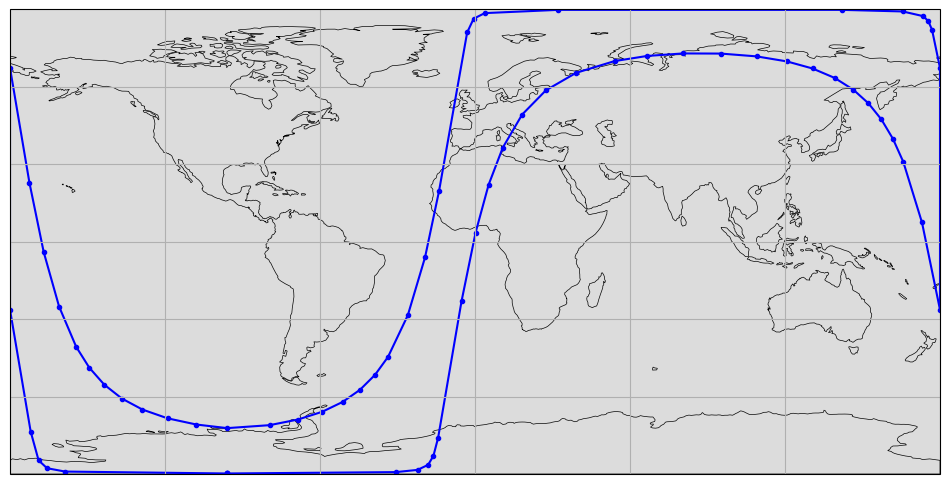

In [17]:
wkt_files = ["./footprints/"+f for f in os.listdir("./footprints/") if f.endswith(".wkt")]

for fn_wkt in wkt_files:
    # Unpack polygon lat, lon point info into two lists:
    lons, lats = unpack_poly(fn_wkt) 

    # Plot polygon:
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=cartopy.crs.PlateCarree(central_longitude=0))    
    if len(lons) == 1:
        ax.plot(lons[0], lats[0], 'b.-')
    elif len(lons) == 2:
        ax.plot(lons[0], lats[0], 'b.-')
        ax.plot(lons[1], lats[1], 'b.-')
        
    ax.gridlines()
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro')
    ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black', linewidth=0.5, facecolor='gainsboro')

# 4. Upload config file to forge-tig-configuration repo
If the config file passes the required tests, it can be uploaded to the tig-forge-configuration repo https://github.com/podaac/forge-tig-configuration via a PR using the following steps: 

**Steps Outlined Here (in more detail further down)**
1. Copy each short name .cfg file to the forge-tig-configuration repo under "config-files"
2. Update the CHANGELOG.md in forge-tig-configuration listing your changes
3. Commit and push the new updates in the cloned `forge-tig-configuration` folder to a feature branch.
4. Open a PR in forge-tig-configuration. In the PR, include reviewers James Wood, Simon Liu, and Jack McNelis, and let them know it's ready in Slack.

**Steps in detail:**

In [ ]:
## step 1
#Copies the .cfg file to the required folder:
shutil.copyfile(config_file, "./forge-tig-configuration/config-files/" + config_file.split("/")[-1])

**step 2**

Update `CHANGELOG.md`:
Add the following lines, modified as needed to reflect changes, e.g.:
```
## [Released] - yyyy-mm-dd

### Added
 - Added config for <shortname>
### Changed
### Deprecated
### Removed
### Fixed
### Security

```

**step 3**

Commands for committing and pushing to new branch once inside the directory `forge-tig-configuration`:

```
cd forge-tig-configuration
git branch feature/<name>
git checkout feature/<name>
git add config-files/<shortname.cfg> CHANGELOG.md
git commit -m "<commit message>"
git push -u origin feature/<name>
```

**step 4**

Then create a PR in https://github.com/podaac/forge-tig-configuration, include reviewers James Wood and Simon Liu, and let them know it's ready in Slack

# 5. Next steps for testing subsetting capabilities, specifically L2SS and HiTIDE

If the tested collections will go into HiTIDE or have L2SS enabled, they should be tested for these compatibilities. There are several methods to go about it outlined below. 

Before these tools/services will work, the UMM-G's for the granules to be tested (and ultimately all UMM-G's for the collection) need to contain footprint polygon data (Section 3). This is so L2SS can query the UMM-G for spatial coverage info, e.g. to subset data or determine if data for a granule exists within a desired region. If this work is being done before the test/ops ingest stage, TVA may be able to automate the process to occur in line with ingest and UMM-G generation. If this work is being done after ingest / UMM-G gen, TVA will need to "backfill", that is modify the UMM-G's post-creation. Once this is complete, the following tests can be done: 


### 5.1 Testig in UAT
First the collections should be associated with L2SS (service) and HiTIDE (tool) in MMT UAT. The link for MMT UAT is https://mmt.uat.earthdata.nasa.gov. For L2SS the service should be called "PODAAC Level 2 Cloud Subsetter". Once confirmed that the collections were successfully associated, HiTIDE in UAT can be used for testing. Things that should be tested with HiTIDE:
* Collection info page (using the (i) icon)
* granule thumbnails
* granule footprints
* Doing a subset by selecting a small region and select to download
* Doing a merge of multiple granules in the download area
If issues are run into for any of these tests, contact the TVA team for guidance.


### 5.2 Testig in Ops
Once UAT testing is completed and the collection is ingest to Ops, the same testing steps can be carried out (e.g. service/tool associations, testing in HiTIDE), but in the Ops environment instead of UAT.


### 5.3 Low level testing
This type of testing becomes relevant when a collection will have L2SS services but will not be in HiTIDE. Data Publication Team can test a collection with L2SS using the software/instructions here https://github.com/podaac/l2ss-py (or pypi link here https://pypi.org/project/l2ss-py/). ***The software/tests can be run before a collection is fully ingested, as long as UMM-G bounding polygon info is present.***


### 5.4 Other info
TVA also keeps a record of HiTIDE collection associations in this sheet: https://docs.google.com/spreadsheets/d/1GpLzAUivhIPb28Rte7LEJmDNAbpPtpm26aW4Fg2dFBo/edit#gid=1493379643 

# 6. Other notes

## 6.1 Footprint Strategies

The current options for footprint strategy are *periodic*, *linestring*, *polar*, *polarsides*, *smap*, and *swot_linestring*.

Below are examples of collections that use each strategy:

**periodic**

* AQUARIUS_L2_SSS_V4
* AQUARIUS_L2_SSS_V5
* QSCAT_LEVEL_2B_OWV_COMP_12_KUSST_LCRES_4.1
* QSCAT_LEVEL_2B_OWV_COMP_12_LCR_3.1
* VIIRS_NPP-NAVO-L2P-v1.0
* AVHRRF_MC-STAR-L2P-v2.80
* ASCATC-L2-25km
* AMSR2-REMSS-L2P-v8.2
* VIIRS_NPP-NAVO-L2P-v3.0
* ASCATA-L2-Coastal
* AMSR2-REMSS-L2P_RT-v8.2
* SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_CALVAL_V1
* VIIRS_NPP-OSPO-L2P-v2.41
* ASCATC-L2-Coastal
* MODIS_T-JPL-L2P-v2019.0
* VIIRS_N20-OSPO-L2P-v2.61
* RSCAT_LEVEL_2B_OWV_COMP_12_V1.2
* AVHRR_SST_METOP_B-OSISAF-L2P-v1.0
* VIIRS_NPP-JPL-L2P-v2016.2
* VIIRS_NPP-NAVO-L2P-v2.0
* RSCAT_LEVEL_2B_OWV_COMP_12_V1.1
* ASCATB-L2-Coastal
* MODIS_A-JPL-L2P-v2019.0


**linestring**

* JASON-1_L2_OST_GPS_E.
* JASON_CS_S6A_L2_ALT_HR_STD_OST_NRT_F
* JASON-1_L2_OST_GPN_E
* JASON_CS_S6A_L2_ALT_LR_STD_OST_STC_F
* JASON_3_L2_OST_OGDR_GPS
* JASON_CS_S6A_L2_ALT_LR_RED_OST_NRT_F
* JASON-1_L2_OST_GPR_E
* SWOT_SIMULATED_L2_NADIR_SSH_GLORYS_CALVAL_V1
* JASON_CS_S6A_L2_ALT_HR_RED_OST_STC_F
* OSTM_L2_OST_OGDR_GPS
* SWOT_SIMULATED_L2_NADIR_SSH_GLORYS_SCIENCE_V1
* JASON_CS_S6A_L2_ALT_HR_STD_OST_STC_F
* JASON_CS_S6A_L2_AMR_RAD_STC
* MERGED_TP_J1_OSTM_OST_CYCLES_V42
* SWOT_SIMULATED_L2_NADIR_SSH_ECCO_LLC4320_SCIENCE_V1
* JASON_CS_S6A_L2_ALT_LR_STD_OST_NRT_F
* ALTIKA_SARAL_L2_OST_XOGDR
* JASON_CS_S6A_L2_ALT_LR_RED_OST_STC_F
* SWOT_SIMULATED_L2_NADIR_SSH_ECCO_LLC4320_CALVAL_V1
* JASON_CS_S6A_L2_AMR_RAD_NRT
* JASON_CS_S6A_L2_ALT_HR_RED_OST_NRT_F

**polar**

* NAVO-L2P-AVHRR19_G
* AVHRR19_G-NAVO-L2P-v1.0

**polarsides**

* OS2_OSCAT_LEVEL_2B_OWV_COMP_12_V2
* AVHRRMTA_G-NAVO-L2P-v1.0
* AVHRRMTB_G-NAVO-L2P-v1.0
* SMAP_JPL_L2B_NRT_SSS_CAP_V5

**smap**

* SMAP_RSS_L2_SSS_V5                
* SMAP_RSS_L2_SSS_V4            
* SMAP_JPL_L2B_SSS_CAP_V5

**swot_linestring**

* SWOT_L2_NALT_IGDR_1.0
* SWOT_L2_NALT_IGDR_2.0
* SWOT_L2_NALT_OGDR_2.0
* SWOT_L2_NALT_GDR_SSHA_1.0
* SWOT_L2_NALT_IGDR_SSHA_1.0
* SWOT_L2_NALT_OGDR_SSHA_2.0
* SWOT_L2_NALT_OGDR_1.0
* SWOT_L2_NALT_IGDR_SSHA_2.0
* SWOT_L2_NALT_GDR_SSHA_2.0
* SWOT_L2_NALT_OGDR_SSHA_1.0

## 6.2 Optional: Installing tig package with pip

If you opt for this method to obtain the tig software, follow these steps:

The podaac-tig library is in https://pypi.org/project/podaac-tig/ , so pypi should be added to your `~/pip/pip.conf` file before using pip to install the package. E.g. the `pip.conf` should have the lines
```
[global]
index-url = https://pypi.org/simple
trusted-host = pypi.org
```
Then, the podaac-tig library can be installed with 
```
pip install podaac-tig==0.9.0
```
and the packages can be imported using
```
from podaac.tig import generate_hitide_config
from podaac.tig import tig
```